## 2.6 Q学習で迷路を攻略

In [12]:
# 宣告使用的套件
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


C:\Users\baris\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


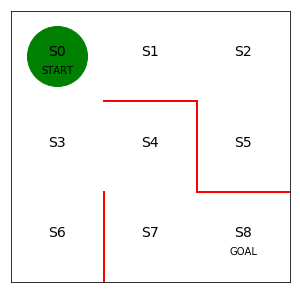

In [13]:
# 迷宮的初始狀態

# 宣告圖的大小與圖的變數名稱
fig = plt.figure(figsize=(5, 5))
ax = plt.gca()

# 繪製紅色牆壁
plt.plot([1, 1], [0, 1], color='red', linewidth=2)
plt.plot([1, 2], [2, 2], color='red', linewidth=2)
plt.plot([2, 2], [2, 1], color='red', linewidth=2)
plt.plot([2, 3], [1, 1], color='red', linewidth=2)

# 繪製代表狀態的文字S0～S8
plt.text(0.5, 2.5, 'S0', size=14, ha='center')
plt.text(1.5, 2.5, 'S1', size=14, ha='center')
plt.text(2.5, 2.5, 'S2', size=14, ha='center')
plt.text(0.5, 1.5, 'S3', size=14, ha='center')
plt.text(1.5, 1.5, 'S4', size=14, ha='center')
plt.text(2.5, 1.5, 'S5', size=14, ha='center')
plt.text(0.5, 0.5, 'S6', size=14, ha='center')
plt.text(1.5, 0.5, 'S7', size=14, ha='center')
plt.text(2.5, 0.5, 'S8', size=14, ha='center')
plt.text(0.5, 2.3, 'START', ha='center')
plt.text(2.5, 0.3, 'GOAL', ha='center')

# 設定繪圖範圍與塗銷刻度
ax.set_xlim(0, 3)
ax.set_ylim(0, 3)
plt.tick_params(axis='both', which='both', bottom='off', top='off',
                labelbottom='off', right='off', left='off', labelleft='off')

# 於目前位置S0繪製綠色圓形
line, = ax.plot([0.5], [2.5], marker="o", color='g', markersize=60)


In [14]:
# 設定一開始採用何種策略的參數theta_0

# 列為狀態0～7、欄移動方向的↑、→、↓、←
theta_0 = np.array([[np.nan, 1, 1, np.nan],  # s0
                    [np.nan, 1, np.nan, 1],  # s1
                    [np.nan, np.nan, 1, 1],  # s2
                    [1, 1, 1, np.nan],  # s3
                    [np.nan, np.nan, 1, 1],  # s4
                    [1, np.nan, np.nan, np.nan],  # s5
                    [1, np.nan, np.nan, np.nan],  # s6
                    [1, 1, np.nan, np.nan],  # s7、※s8是終點，所以不需採用任何策略
                    ])


In [15]:
# 自訂策略的參數theta轉換成行動策略pi的函數


def simple_convert_into_pi_from_theta(theta):
    '''單純地計算比例'''

    [m, n] = theta.shape  # 取得theta的矩陣大小
    pi = np.zeros((m, n))
    for i in range(0, m):
        pi[i, :] = theta[i, :] / np.nansum(theta[i, :])  # 計算比例

    pi = np.nan_to_num(pi)  # 將nan轉換成0

    return pi

# 求得隨機採取行動的策略pi_0
pi_0 = simple_convert_into_pi_from_theta(theta_0)


In [16]:
# 設定初始的動作價值函數Q

[a, b] = theta_0.shape  # 將列與欄的數字分別存入a與b
Q = np.random.rand(a, b) * theta_0 * 0.1
# * theta0可乘上每個元素，在Q為朝向牆壁的值，將該值設定為nan


In [17]:
# 建置ε-greedy法


def get_action(s, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]

    # 決定動作
    if np.random.rand() < epsilon:
        # 根據ε的機率隨機移動
        next_direction = np.random.choice(direction, p=pi_0[s, :])
    else:
        # 採用Q為最大值的動作
        next_direction = direction[np.nanargmax(Q[s, :])]

    # 將動作存入index
    if next_direction == "up":
        action = 0
    elif next_direction == "right":
        action = 1
    elif next_direction == "down":
        action = 2
    elif next_direction == "left":
        action = 3

    return action


def get_s_next(s, a, Q, epsilon, pi_0):
    direction = ["up", "right", "down", "left"]
    next_direction = direction[a]  # 動作a的方向

    # 根據動作決定下一個狀態
    if next_direction == "up":
        s_next = s - 3  # 向上移動時，狀態的數字減3
    elif next_direction == "right":
        s_next = s + 1  # 向右移動時，狀態的數字加1
    elif next_direction == "down":
        s_next = s + 3  # 向下移動時，狀態的數字加3
    elif next_direction == "left":
        s_next = s - 1  # 向左移動時，狀態的數字減1

    return s_next


In [18]:
# 以Q學習更新動作價值函數Q的部分


def Q_learning(s, a, r, s_next, Q, eta, gamma):

    if s_next == 8:  # 抵達終點的情況
        Q[s, a] = Q[s, a] + eta * (r - Q[s, a])

    else:
        Q[s, a] = Q[s, a] + eta * (r + gamma * np.nanmax(Q[s_next,: ]) - Q[s, a])

    return Q

In [19]:
# 定義以Q學習走出迷宮的函數，輸出狀態、動作的履歷與更新之後的Q


def goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi):
    s = 0  # 起點
    a = a_next = get_action(s, Q, epsilon, pi)  # 初始的行動
    s_a_history = [[0, np.nan]]  # 記錄代理器移動軌跡的list

    while (1):  # 在抵達終點之前不斷執行的迴圈
        a = a_next  # 更新動作

        s_a_history[-1][1] = a
        # 將動作代入目前的狀態（由於是最後一個動作，所以index=-1）

        s_next = get_s_next(s, a, Q, epsilon, pi)
        # 儲存下一個狀態

        s_a_history.append([s_next, np.nan])
        # 代入下一個狀態。由於還不知道會是什麼動作，所以先設定為nan

        # 給予報酬，計算下一個動作
        if s_next == 8:
            r = 1  # 若已抵達終點就給予報酬
            a_next = np.nan
        else:
            r = 0
            a_next = get_action(s_next, Q, epsilon, pi)
            # 計算下一個動作a_next

        # 更新價值函數
        Q = Q_learning(s, a, r, s_next, Q, eta, gamma)

        # 結束條件
        if s_next == 8:  # 若已抵達終點，就結束程式
            break
        else:
            s = s_next

    return [s_a_history, Q]


In [21]:
# 以Q學習走出迷宮

eta = 0.1  # 學習率
gamma = 0.9  # 時間折扣率
epsilon = 0.5  # ε-greedy法的初始值
v = np.nanmax(Q, axis=1)  # 計算價值在每個狀態之下的最大值
is_continue = True
episode = 1

V = []  # 儲存每回合的狀態價值
V.append(np.nanmax(Q, axis=1))  # 計算動作價值在每個狀態下的最大值

while is_continue:  # 不斷執行，直到is_continue等於False為止
    print("回合:" + str(episode))

    # 遞減ε-greedy的值
    epsilon = epsilon / 2

    # 以Q學習走出迷宮，得出移動軌跡與更新之後的Q
    [s_a_history, Q] = goal_maze_ret_s_a_Q(Q, epsilon, eta, gamma, pi_0)

    # 狀態價值的變化
    new_v = np.nanmax(Q, axis=1)  # 計算動作價值在每個狀態下的最大值
    print(np.sum(np.abs(new_v - v)))  # 輸出狀態價值的變化
    v = new_v
    V.append(v)  # 追加在這個回合結束時的狀態價值函數

    print("走出迷宮的總步數為" + str(len(s_a_history) - 1) + "步")

    # 重覆執行100回合
    episode = episode + 1
    if episode > 100:
        break


回合:1
0.0005604551303218797
走出迷宮的總步數為4步
回合:2
0.0005181565920461262
走出迷宮的總步數為4步
回合:3
0.00047893847513202914
走出迷宮的總步數為4步
回合:4
0.0004425870008304411
走出迷宮的總步數為4步
回合:5
0.00040890222525058473
走出迷宮的總步數為4步
回合:6
0.00037769724030922713
走出迷宮的總步數為4步
回合:7
0.0003487974112829084
走出迷宮的總步數為4步
回合:8
0.00032203965030142
走出迷宮的總步數為4步
回合:9
0.00029727172500548793
走出迷宮的總步數為4步
回合:10
0.0002743516014883651
走出迷宮的總步數為4步
回合:11
0.00025314682056765125
走出迷宮的總步數為4步
回合:12
0.00023353390636382532
走出迷宮的總步數為4步
回合:13
0.000215397806114348
走出迷宮的總步數為4步
回合:14
0.00019863136012288063
走出迷宮的總步數為4步
回合:15
0.00018313480070875077
走出迷宮的總步數為4步
回合:16
0.00016881527901813076
走出迷宮的總步數為4步
回合:17
0.00015558641854818145
走出迷宮的總步數為4步
回合:18
0.00014336789423463614
走出迷宮的總步數為4步
回合:19
0.00013208503597283983
走出迷宮的總步數為4步
回合:20
0.0001216684554448122
走出迷宮的總步數為4步
回合:21
0.00011205369515132624
走出迷宮的總步數為4步
回合:22
0.00010318089857330737
走出迷宮的總步數為4步
回合:23
9.499450040306723e-05
走出迷宮的總步數為4步
回合:24
8.744293582896301e-05
走出迷宮的總步數為4步
回合:25
8.047836787650198e-05
走出迷宮的總步數為4

In [23]:
# 將狀態價值的變化繪製成圖
# 參考URL http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm  # color map


def init():
    # 初始化背景影像
    line.set_data([], [])
    return (line,)


def animate(i):
    # 每一格影格的繪圖內容
    # 在每一格繪製與狀態價值相同大小的彩色四邊形
    line, = ax.plot([0.5], [2.5], marker="s",
                    color=cm.jet(V[i][0]), markersize=85)  # S0
    line, = ax.plot([1.5], [2.5], marker="s",
                    color=cm.jet(V[i][1]), markersize=85)  # S1
    line, = ax.plot([2.5], [2.5], marker="s",
                    color=cm.jet(V[i][2]), markersize=85)  # S2
    line, = ax.plot([0.5], [1.5], marker="s",
                    color=cm.jet(V[i][3]), markersize=85)  # S3
    line, = ax.plot([1.5], [1.5], marker="s",
                    color=cm.jet(V[i][4]), markersize=85)  # S4
    line, = ax.plot([2.5], [1.5], marker="s",
                    color=cm.jet(V[i][5]), markersize=85)  # S5
    line, = ax.plot([0.5], [0.5], marker="s",
                    color=cm.jet(V[i][6]), markersize=85)  # S6
    line, = ax.plot([1.5], [0.5], marker="s",
                    color=cm.jet(V[i][7]), markersize=85)  # S7
    line, = ax.plot([2.5], [0.5], marker="s",
                    color=cm.jet(1.0), markersize=85)  # S8
    return (line,)


#　利用初始化函數與每格影格的繪圖函數繪製動畫
anim = animation.FuncAnimation(
    fig, animate, init_func=init, frames=len(V), interval=200, repeat=False)

HTML(anim.to_jshtml())
